In [1]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

# from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
# from sklearn.decomposition import PCA
# from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

# hv.renderer('bokeh').theme = 'dark_minimal'


In [2]:
# dataset_root = Path(r"C:\Users\Turquin\Documents\MLFPMA - Machine Learning for Predictive Maintenance Application\Project\Dataset") # Raw string works without escaping \
dataset_root = Path("./Dataset")

@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():
    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False, load_anomalies=False) -> None:
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }

        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }

        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }

        if load_anomalies:
            anomaly_folder = Path("synthetic_anomalies")  # Relative path
            subdataset = ["01", "02"]
            anomaly_types = ["a", "b", "c"]
            for anomaly in subdataset:
                for subtype in anomaly_types:
                    anomaly_key = f"anomaly_{anomaly}_type_{subtype}"
                    anomaly_file = f"{unit}_anomaly_{anomaly}_type_{subtype}.parquet"
                    full_anomaly_path = root / anomaly_folder / anomaly_file
                    if full_anomaly_path.exists():
                        cases[anomaly_key] = [anomaly_folder / anomaly_file, None]

        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            measurements = read_pq_file(c[0])
            info = pd.read_csv(c[1]) if c[1] is not None else None
            self.data_dict[id_c] = Case(info, measurements)
    
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    

rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True, load_anomalies=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=True, load_training=True, load_anomalies=True)

In [34]:
def add_anomaly_ground_truth(rds):
    subdataset = ["01", "02"]
    anomaly_types = ["a", "b", "c"]

    results = []
    for anomaly in subdataset:
        test_s012 = rds.data_dict[f'test_s{anomaly}'].measurements

        for subtype in anomaly_types:
            anomaly_key = f"anomaly_{anomaly}_type_{subtype}"
            labeled_df = rds.data_dict[anomaly_key].measurements
            test_s012.loc[labeled_df['ground_truth'] == 1, anomaly_key] = 1
        
        test_s012['anomaly'] = (test_s012[[f'anomaly_{anomaly}_type_a',f'anomaly_{anomaly}_type_b',f'anomaly_{anomaly}_type_c']].max(axis=1) == 1).astype(int)
        results.append(test_s012)

    return results

u5_s01, u5_s02 = add_anomaly_ground_truth(rds_u5)
u6_s01, u6_s02 = add_anomaly_ground_truth(rds_u6)

In [35]:
def anomaly_na(df):
    cols_anomaly = [col for col in df.columns if 'anomaly' in col]
    df[cols_anomaly] = df[cols_anomaly].fillna(0)
    return df 

anomaly_na(u5_s01)
anomaly_na(u5_s02)
anomaly_na(u6_s01)
anomaly_na(u6_s02)


,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,injector_05_opening,...,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode,anomaly_02_type_a,anomaly_02_type_b,anomaly_02_type_c,anomaly
2021-11-01 00:00:00+01:00,0.000000,14.845771,18.216559,4.311914,11.803000,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,0.0,0.0,0.0,0
2021-11-01 00:00:30+01:00,0.000000,14.852612,18.233796,4.464852,11.803000,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,0.0,0.0,0.0,0
2021-11-01 00:01:00+01:00,0.000000,14.859453,18.251033,4.445999,11.803000,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,0.0,0.0,0.0,0
2021-11-01 00:01:30+01:00,0.000000,14.866293,18.268270,4.140497,11.803000,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,0.0,0.0,0.0,0
2021-11-01 00:02:00+01:00,0.000000,14.873134,18.285507,4.453990,11.803000,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 23:58:00+01:00,-120.287556,10.201256,16.065450,-1.854672,185.406032,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,True,False,0.0,0.0,0.0,0
2021-12-30 23:58:30+01:00,-76.832558,10.203748,16.010313,-1.785339,185.403888,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,True,0.0,0.0,0.0,0
2021-12-30 23:59:00+01:00,0.000000,10.206240,15.955176,4.045595,185.401744,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,0.0,0.0,0.0,0
2021-12-30 23:59:30+01:00,0.000000,10.208732,15.900039,4.116665,185.399600,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,0.0,0.0,0.0,0


# Operating Conditions

Separate dataframes by operating conditions and remove unnecessary columns about operating conditions.

In [36]:
def add_cycle_ids(df):
    # Create a new column to track cycle IDs
    df['turbine_cycle_id'] = (df['equilibrium_turbine_mode'].diff().fillna(0).gt(0)).cumsum()
    df['pump_cycle_id'] = (df['equilibrium_pump_mode'].diff().fillna(0).gt(0)).cumsum()
    return df

df4 = add_cycle_ids(rds_u4.data_dict["train"].measurements)
df5 = add_cycle_ids(rds_u5.data_dict["train"].measurements)
df6 = add_cycle_ids(rds_u6.data_dict["train"].measurements)


In [37]:
def get_operating_modes(df):
    df_equilibrium_turbine_mode = df[df['equilibrium_turbine_mode'] == True]
    df_equilibrium_pump_mode = df[df['equilibrium_pump_mode'] == True]

    operating_cond_cols = ['machine_on', 'turbine_mode', 'all', 'dyn_only_on', 'pump_mode',]
    
    if 'short_circuit_mode' in df.columns:
        operating_cond_cols += ['short_circuit_mode', 'equilibrium_short_circuit_mode']
    
    df_equilibrium_turbine_mode = df_equilibrium_turbine_mode.drop(columns = operating_cond_cols)
    df_equilibrium_pump_mode = df_equilibrium_pump_mode.drop(columns = operating_cond_cols)

    return df_equilibrium_turbine_mode, df_equilibrium_pump_mode

# train sets
u4_train_equil_turbine, u4_train_equil_pump = get_operating_modes(df4)
u5_train_equil_turbine, u5_train_equil_pump = get_operating_modes(df5)
u6_train_equil_turbine, u6_train_equil_pump = get_operating_modes(df6)

# synethetic test sets
u5_s01_equil_turbine, u5_s01_equil_pump = get_operating_modes(u5_s01)
u5_s02_equil_turbine, u5_s02_equil_pump = get_operating_modes(u5_s02)
u6_s01_equil_turbine, u6_s01_equil_pump = get_operating_modes(u6_s01)
u6_s02_equil_turbine, u6_s02_equil_pump = get_operating_modes(u6_s02)

# real test sets
u4_test_equil_turbine, u4_test_equil_pump = get_operating_modes(rds_u4.data_dict["test"].measurements)
u5_test_equil_turbine, u5_test_equil_pump = get_operating_modes(rds_u5.data_dict["test"].measurements)
u6_test_equil_turbine, u6_test_equil_pump = get_operating_modes(rds_u6.data_dict["test"].measurements)

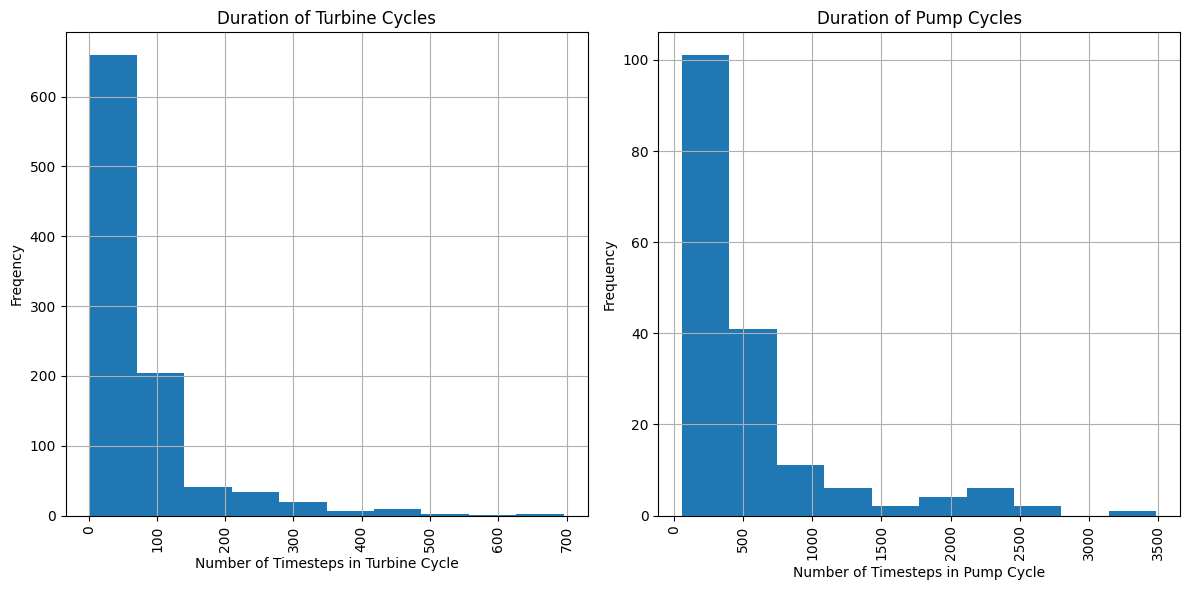

In [38]:
def plot_cycle_sizes(df_turbine, df_pump):
    # Count the number of rows in each cycle for turbine and pump
    turbine_cycle_sizes = df_turbine['turbine_cycle_id'].value_counts()
    pump_cycle_sizes = df_pump['pump_cycle_id'].value_counts()

    # Create a plot for turbine cycles
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # Two plots side by side
    turbine_cycle_sizes.hist()
    plt.title('Duration of Turbine Cycles')
    plt.xlabel('Number of Timesteps in Turbine Cycle')
    plt.ylabel('Freqency')
    plt.xticks(rotation=90)

    # Create a plot for pump cycles
    plt.subplot(1, 2, 2)
    pump_cycle_sizes.hist()
    plt.title('Duration of Pump Cycles')
    plt.xlabel('Number of Timesteps in Pump Cycle')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_cycle_sizes(u4_train_equil_turbine, u4_train_equil_pump)


Most cycles last for over 20 rows/timestamps in turbine mode, and over 12 cycles in pump mode. Therefore, drop cycles with less than this # of timestamps.

In [39]:
def filter_cycles(df, mode_name, min_cycle_length=20):
    # Drop cycles with fewer than 12 timestamps
    cycle_counts = df[f"{mode_name}_cycle_id"].value_counts()
    valid_cycles = cycle_counts[cycle_counts >= min_cycle_length].index
    df_filtered = df[df[f"{mode_name}_cycle_id"].isin(valid_cycles)]

    # Calculate and print the percentage of data removed
    removed_percentage = (1 - len(df_filtered) / len(df)) * 100
    print(f"Percentage of data removed from {mode_name}: {removed_percentage:.2f}%")
    
    return df_filtered

u4_train_equil_turbine = filter_cycles(u4_train_equil_turbine, 'turbine', 20)
u4_train_equil_pump = filter_cycles(u4_train_equil_pump, 'pump', 200)

u5_train_equil_turbine = filter_cycles(u5_train_equil_turbine, 'turbine', 20)
u5_train_equil_pump = filter_cycles(u5_train_equil_pump, 'pump', 200)

u6_train_equil_turbine = filter_cycles(u6_train_equil_turbine, 'turbine', 20)
u6_train_equil_pump = filter_cycles(u6_train_equil_pump, 'pump', 200)

Percentage of data removed from turbine: 4.99%
Percentage of data removed from pump: 8.23%
Percentage of data removed from turbine: 1.13%
Percentage of data removed from pump: 6.53%
Percentage of data removed from turbine: 0.94%
Percentage of data removed from pump: 3.55%


In [40]:
# Separating the list into the required categories
u4_pump_dfs = [
    u4_train_equil_pump,
    u4_test_equil_pump
]

u4_turbine_dfs = [
    u4_train_equil_turbine,
    u4_test_equil_turbine
]

u5_pump_dfs = [
    u5_train_equil_pump,
    u5_s01_equil_pump,
    u5_s02_equil_pump,
    u5_test_equil_pump
]

u5_turbine_dfs = [
    u5_train_equil_turbine,
    u5_s01_equil_turbine,
    u5_s02_equil_turbine,
    u5_test_equil_turbine
]

u6_pump_dfs = [
    u6_train_equil_pump,
    u6_s01_equil_pump,
    u6_s02_equil_pump,
    u6_test_equil_pump
]

u6_turbine_dfs = [
    u6_train_equil_turbine,
    u6_s01_equil_turbine,
    u6_s02_equil_turbine,
    u6_test_equil_turbine
]

all_dfs = u4_pump_dfs + u4_turbine_dfs + u5_pump_dfs + u5_turbine_dfs + u6_pump_dfs + u6_turbine_dfs


# Additional Features

##### Injector Openings
Created scaled sum of injector openings, as instructed in the project guidelines. Openings Must range from 0 to 100%

In [41]:
def create_injector_opening_feature(df):
    if 'scaled_injector_sum' not in df.columns:
        injector_columns = [col for col in df.columns if ('injector' in col and 'opening' in col)]
        # print(injector_columns)
        df['scaled_injector_sum'] = df[injector_columns].sum(axis=1)/ len(injector_columns)
        df.drop(columns = injector_columns, inplace=True)
    return df

for i in range(len(all_dfs)):
    all_dfs[i] = create_injector_opening_feature(all_dfs[i])

In [42]:
# def baseline_anomaly_score(df):
#     '''Anomaly score based soley on injector opening. 
#     If an injector is less than 0% open or more than 100% open, it's an anomaly. 
#     This happens in synethtic anomaly type 1 b.'''

#     injector_columns = [col for col in df.columns if ('injector' in col and 'opening' in col)]
#     df['anomaly_score'] = df[injector_columns].apply(lambda row: (row < 0).any() or (row > 100).any(), axis=1).astype(int)
#     return df

# for i in range(len(u5_pump_dfs)):
#     u5_pump_dfs[i] = baseline_anomaly_score(u5_pump_dfs[i])

##### Aggregate features by mean to reduce the number of features.
Affected columns: water_circ_hot_tmp, water_circ_cold_tmp, air_circ_hot_tmp, air_circ_cold_tmp, stat_magn_temp, agg_stat_coil_temp 

In [43]:
def agg_stat_coil_temp(df):
    stat_coil_columns = [col for col in df.columns if ('stat_coil_ph' in col and 'mean' not in col)]
    # print(stat_coil_columns)
    df['stat_coil_tmp_mean'] = df[stat_coil_columns].sum(axis=1)/ len(stat_coil_columns)
    df.drop(columns = stat_coil_columns, inplace=True)
    return df

def agg_stat_magn_temp(df):
    stat_magn_columns = [col for col in df.columns if ('stat_magn' in col and 'mean' not in col)]
    # print(stat_magn_columns)
    df['stat_magn_tmp_mean'] = df[stat_magn_columns].sum(axis=1)/ len(stat_magn_columns)
    df.drop(columns = stat_magn_columns, inplace=True)
    return df

def agg_air_circ_cold_tmp(df):
    air_circ_cold_tmp_columns = [col for col in df.columns if ('air_circ_cold' in col and 'mean' not in col)]
    # print(air_circ_cold_tmp_columns)
    df['air_circ_cold_tmp_mean'] = df[air_circ_cold_tmp_columns].sum(axis=1)/ len(air_circ_cold_tmp_columns)
    df.drop(columns = air_circ_cold_tmp_columns, inplace=True)
    return df

def agg_air_circ_hot_tmp(df):
    air_circ_hot_tmp_columns = [col for col in df.columns if ('air_circ_hot' in col and 'mean' not in col)]
    df['air_circ_hot_tmp_mean'] = df[air_circ_hot_tmp_columns].sum(axis=1)/ len(air_circ_hot_tmp_columns)
    df.drop(columns = air_circ_hot_tmp_columns, inplace=True)
    return df

def agg_water_circ_cold_tmp(df):
    water_circ_cold_tmp_columns = [col for col in df.columns if ('water_circ_cold' in col and 'mean' not in col)]
    df['water_circ_cold_tmp_mean'] = df[water_circ_cold_tmp_columns].sum(axis=1)/ len(water_circ_cold_tmp_columns)
    df.drop(columns = water_circ_cold_tmp_columns, inplace=True)
    return df

def agg_water_circ_hot_tmp(df):
    water_circ_hot_tmp_columns = [col for col in df.columns if ('water_circ_hot' in col and 'mean' not in col)]
    df['water_circ_hot_tmp_mean'] = df[water_circ_hot_tmp_columns].sum(axis=1)/ len(water_circ_hot_tmp_columns)
    df.drop(columns = water_circ_hot_tmp_columns, inplace=True)
    return df

for i in range(len(all_dfs)):
    all_dfs[i] = agg_water_circ_hot_tmp(agg_water_circ_cold_tmp(agg_air_circ_hot_tmp(agg_air_circ_cold_tmp(agg_stat_magn_temp(agg_stat_coil_temp(all_dfs[i]))))))

Delete more useless columns

In [44]:
cols_to_drop = ['machine_off', 'equilibrium_turbine_mode', 'equilibrium_pump_mode', 'turbine_cycle_id', 'pump_cycle_id']

for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i].drop([col for col in cols_to_drop if col in all_dfs[i].columns], axis=1)


In [65]:
for i in range(len(u4_pump_dfs)):
    u4_pump_dfs[i] = u4_pump_dfs[i].drop([col for col in cols_to_drop if col in u4_pump_dfs[i].columns], axis=1)
    u4_turbine_dfs[i] = u4_turbine_dfs[i].drop([col for col in cols_to_drop if col in u4_turbine_dfs[i].columns], axis=1)    

for i in range(len(u5_pump_dfs)):
    u5_pump_dfs[i] = u5_pump_dfs[i].drop([col for col in cols_to_drop if col in u5_pump_dfs[i].columns], axis=1)  
    u5_turbine_dfs[i] = u5_turbine_dfs[i].drop([col for col in cols_to_drop if col in u5_turbine_dfs[i].columns], axis=1)  
    u6_pump_dfs[i] = u6_pump_dfs[i].drop([col for col in cols_to_drop if col in u6_pump_dfs[i].columns], axis=1)
    u6_turbine_dfs[i] = u6_turbine_dfs[i].drop([col for col in cols_to_drop if col in u6_turbine_dfs[i].columns], axis=1)    

##### Add Lags to every col for Temporality

In [45]:
# def add_lag(df, lag, columns = ''):
#     """Adds lagged features to selected columns."""
#     lagged_df = df.copy()
#     if columns == '':
#         columns = df.columns
#     for col in columns:
#         for lag_step in range(1, lag + 1):
#             lagged_df[f"{col}_lag_{lag_step}"] = lagged_df[col].shift(lag_step)

#     lagged_df = lagged_df.dropna().reset_index(drop=True)
#     return lagged_df

# add_lag(all_dfs[2], 2, u5_control_vars)

# Standardize columns

In [69]:
def get_cols_to_standardize(df):
    non_boolean_columns = df.select_dtypes(exclude='bool').columns
    non_anomaly_columns = [col for col in df.columns if ('anomaly' not in col) and ('cycle_id' not in col)]

    return non_anomaly_columns


cols_to_scale4 = get_cols_to_standardize(u4_pump_dfs[0])
cols_to_scale56 = get_cols_to_standardize(u5_pump_dfs[0])

In [70]:
# Define columns to scale
scaler = StandardScaler()

# Function to scale specific columns
def scale_columns(df, cols_to_scale, scaler):
    df_scaled = df.copy()
    if not set(cols_to_scale).issubset(df.columns):
        difference = [col for col in cols_to_scale if col not in df.columns]
        print(difference)
        raise ValueError("Some columns in cols_to_scale are not present in the DataFrame.")
    # Scale only the specified columns
    df_scaled[cols_to_scale] = scaler.transform(df[cols_to_scale])
    return df_scaled

# u4 pump
scaler.fit(u4_train_equil_pump[cols_to_scale4])
for i in range(len(u4_pump_dfs)):
    u4_pump_dfs[i] = scale_columns(u4_pump_dfs[i], cols_to_scale4, scaler)

# u4 turbine
scaler.fit(u4_train_equil_turbine[cols_to_scale4])

for i in range(len(u4_turbine_dfs)):
    u4_turbine_dfs[i] = scale_columns(u4_turbine_dfs[i], cols_to_scale4, scaler)

# u5 pump
scaler.fit(u5_train_equil_pump[cols_to_scale56])
for i in range(len(u5_pump_dfs)):
    u5_pump_dfs[i] = scale_columns(u5_pump_dfs[i], cols_to_scale56, scaler)


# u5 turbine
scaler.fit(u5_train_equil_turbine[cols_to_scale56])
for i in range(len(u5_turbine_dfs)):
    u5_turbine_dfs[i] = scale_columns(u5_turbine_dfs[i], cols_to_scale56, scaler)

# u6 pump
scaler.fit(u6_train_equil_pump[cols_to_scale56])
for i in range(len(u6_pump_dfs)):
    u6_pump_dfs[i] = scale_columns(u6_pump_dfs[i], cols_to_scale56, scaler)

# u6 turbine
scaler.fit(u6_train_equil_turbine[cols_to_scale56])
for i in range(len(u6_turbine_dfs)):
    u6_turbine_dfs[i] = scale_columns(u6_turbine_dfs[i], cols_to_scale56, scaler)

##### Add time features

In [71]:
def add_time_features(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
    return df

for i in range(len(all_dfs)):
    all_dfs[i] = add_time_features(all_dfs[i])

#### Control and Measurement Variables

In [72]:
def get_control_vars(df):
    # I got this list by combining control vars from unit 4, 5, 6
    possible_control_vars = ['tot_activepower', 'coupler_position', 'injector12_pressure',
       'injector34_pressure', 'pump_rotspeed', 'pump_calculated_flow',
       'pump_pressure_diff',
       'scaled_injector_sum', 
       'turbine_rotspeed', 'turbine_pressure', 
       'water_primary_pump_01_opening',
       'water_primary_pump_02_opening'
       'canal_level',
       'canal_tmp', 'lake_tmp', 'ext_tmp', 'plant_tmp']
    
    matching_columns = [col for col in df.columns if col in possible_control_vars]
    
    return matching_columns

def get_measurement_vars(df):
    ''' Anything that's not a control var is a measurement var.'''
    control_vars = get_control_vars(df)
    matching_columns = [col for col in df.columns if col not in control_vars]
    return matching_columns


In [73]:
print('u4_control_vars =', get_control_vars(u4_train_equil_pump))
print('u4_measurement_vars =', get_measurement_vars(u4_train_equil_pump))

print('u5_control_vars =', get_control_vars(u5_train_equil_pump))
print('u5_measurement_vars =', get_measurement_vars(u5_train_equil_pump))

# I think these are the same as u5
# print('u6_control_vars =', get_control_vars(u6_train_equil_pump))
# print('u6_measurement_vars =', get_measurement_vars(u6_train_equil_pump))

u4_control_vars = ['tot_activepower', 'plant_tmp', 'ext_tmp', 'canal_tmp', 'lake_tmp', 'coupler_position', 'injector12_pressure', 'injector34_pressure', 'pump_rotspeed', 'turbine_rotspeed', 'scaled_injector_sum']
u4_measurement_vars = ['water_primary_cold_tmp', 'water_primary_hot_tmp', 'valve_opening', 'refri_bath_level', 'aspi_bath_level', 'canal_level', 'water_primary_filter_out_pressure', 'water_primary_filter_in_pressure', 'tot_reactivepower', 'exc_freq', 'exc_current', 'exc_voltage', 'powerfactor', 'elec_freq', 'ph01_current', 'ph02_current', 'ph03_current', 'ph01_voltage', 'ph12_voltage', 'ph02_voltage', 'ph23_voltage', 'ph03_voltage', 'ph31_voltage', 'machine_off', 'equilibrium_turbine_mode', 'equilibrium_pump_mode', 'turbine_cycle_id', 'pump_cycle_id', 'stat_coil_tmp_mean', 'stat_magn_tmp_mean', 'air_circ_cold_tmp_mean', 'air_circ_hot_tmp_mean', 'water_circ_cold_tmp_mean', 'water_circ_hot_tmp_mean']
u5_control_vars = ['tot_activepower', 'ext_tmp', 'plant_tmp', 'coupler_position

Unpack the dataframes

In [74]:
u4_train_equil_pump, u4_test_equil_pump = u4_pump_dfs
u4_train_equil_turbine, u4_test_equil_turbine = u4_turbine_dfs
u5_train_equil_pump, u5_s01_equil_pump, u5_s02_equil_pump, u5_test_equil_pump = u5_pump_dfs
u5_train_equil_turbine, u5_s01_equil_turbine, u5_s02_equil_turbine, u5_test_equil_turbine = u5_turbine_dfs
u6_train_equil_pump, u6_s01_equil_pump, u6_s02_equil_pump, u6_test_equil_pump = u6_pump_dfs
u6_train_equil_turbine, u6_s01_equil_turbine, u6_s02_equil_turbine, u6_test_equil_turbine = u6_turbine_dfs

In [ ]:
# if you want csv

# u5_train_equil_pump.to_csv('u5_train_equil_pump.csv')
# u5_s01_equil_pump.to_csv('u5_s01_equil_pump.csv')

# u5_train_equil_turbine.to_csv('u5_train_equil_turbine.csv')
# u5_s01_equil_turbine.to_csv('u5_s01_equil_turbine.csv')

Copy this into your notebook to import the variables

In [ ]:
'''
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump
'''

'\n# training data\nu4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine\nu4_train_equil_pump = data_preprocessing.u4_train_equil_pump\nu5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine\nu5_train_equil_pump = data_preprocessing.u5_train_equil_pump\nu6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine\nu6_train_equil_pump = data_preprocessing.u6_train_equil_pump\n\n# synethetic test sets\nu5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine\nu5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump\nu5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine\nu5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump\nu6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine\nu6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump\nu6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine\nu6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump\n\n# real test sets\nu4_test_equil_turbine = data_preprocessing.u4_test_equil

Some examples:

For Unit 4:
- train on u4_train_equil_pump, test on u4_test_equil_pump

For Unit 5:
- train on u5_train_equil_turbine, test on u5_s01_equil_turbine, u5_s02_equil_turbine, u5_test_equil_turbine